# A Study on Arrhythmia via ECG Signal Classification Using the Convolutional Neural Network

The following notebook demonstrates the implementation of the best trial obtained from Optuna for Experiment 1. In this experiment,all the hyperparameters were optimized using Optuna.

### Importing Necessary Libraries


In [1]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras import regularizers
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
import os
from tensorflow.keras.models import load_model
import json
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, accuracy_score


import optuna
%matplotlib inline

### Matplotlib Settings

In [2]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

### 1. Preprocessing - Denoising the signal
This function denoise uses wavelet transform to remove noise from the input signal data. It applies a symmetric 4 (sym4) wavelet and performs a multi-level discrete wavelet decomposition to break the signal into approximation and detail coefficients. The function then thresholds the detail coefficients to filter out noise based on a predefined threshold. Finally, it reconstructs the signal by applying the inverse wavelet transform, returning a cleaner version of the input data.

In [3]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


### 2. Preprocessing – Reading Raw ECG Signals for 48 contiguous ECG excerpts

| **Label** | **Description**                                                                                                                                           |
|-----------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| **N**     | Normal heartbeat or cardiac complex. The electrical activity of the heart is within the normal range, with no abnormalities or irregularities in the heart rhythm. |
| **L**     | Left bundle branch block. An abnormality in the electrical conduction system where signals do not travel normally through the left bundle branch, affecting ventricular contractions. |
| **R**     | Right bundle branch block. An abnormality in the electrical conduction system involving the right bundle branch, similar to left bundle branch block.      |
| **A**     | Atrial premature beat. An early contraction originating in the atria (upper chambers of the heart) before the next expected normal heartbeat.              |
| **V**     | Ventricular premature beat. An early contraction originating in the ventricles (lower chambers of the heart) before the next expected normal heartbeat.     |


In [4]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [5]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [6]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

### 3. Preprocessing - Segmentation into windows of 2000 sample points

<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_23/3133449120.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
/tmp/ipykernel_23/3133449120.py:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
/tmp/ipykernel_23/3133449120.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
/tmp/ipykernel_23/3133449120.py:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1 and not example_beat_printed:


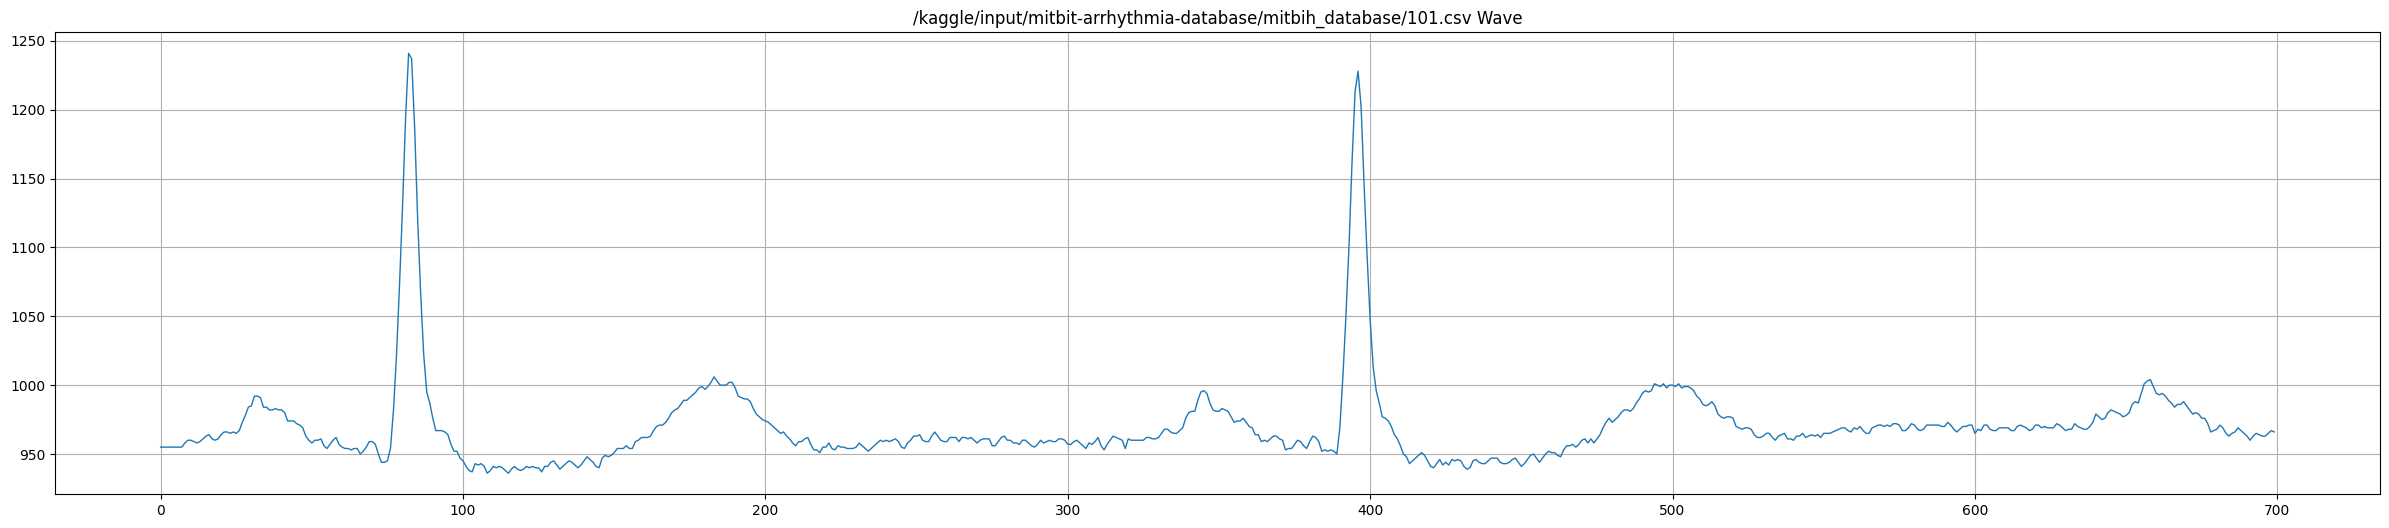

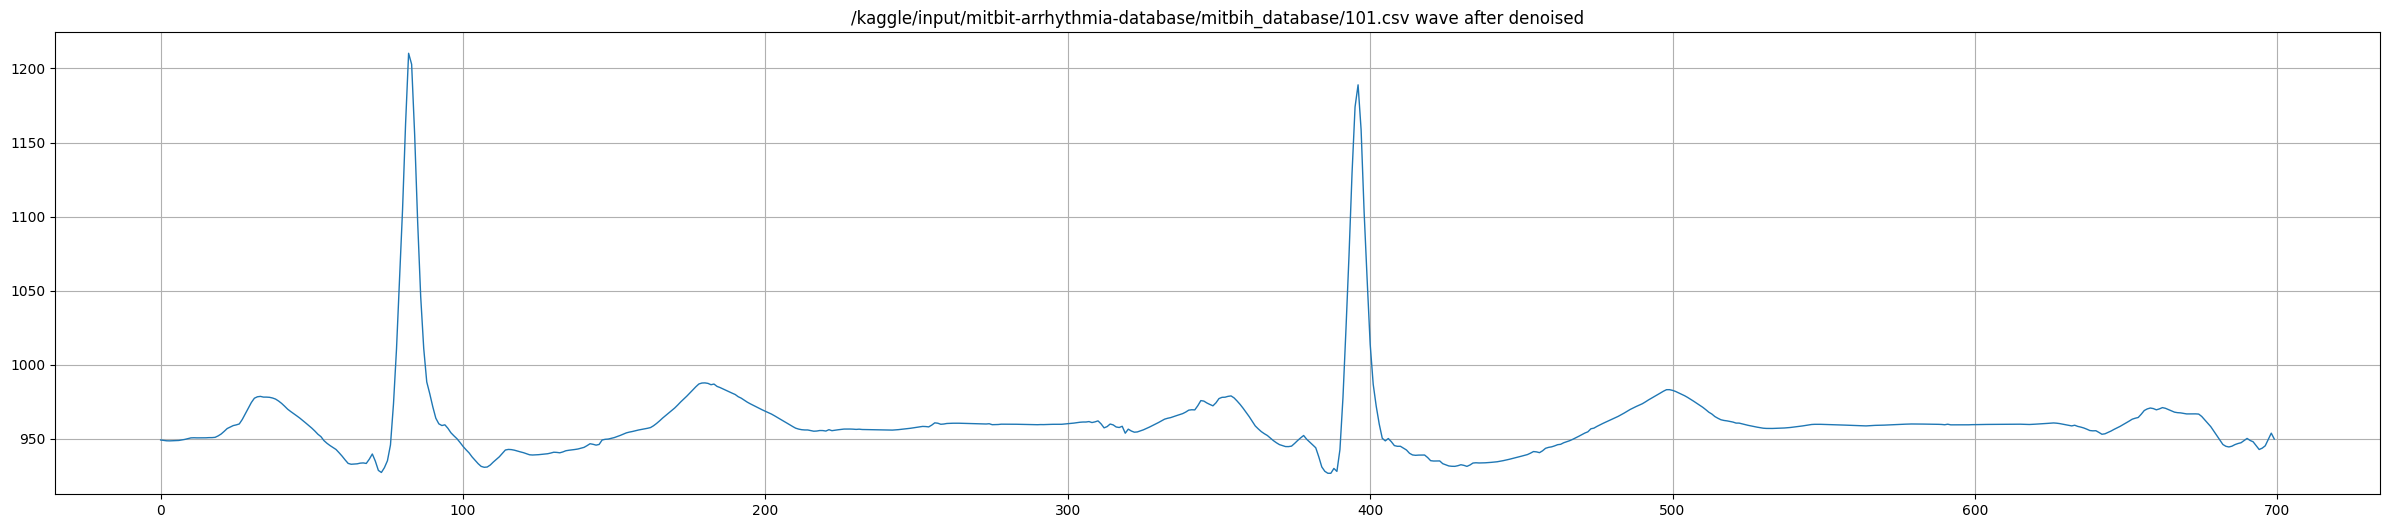

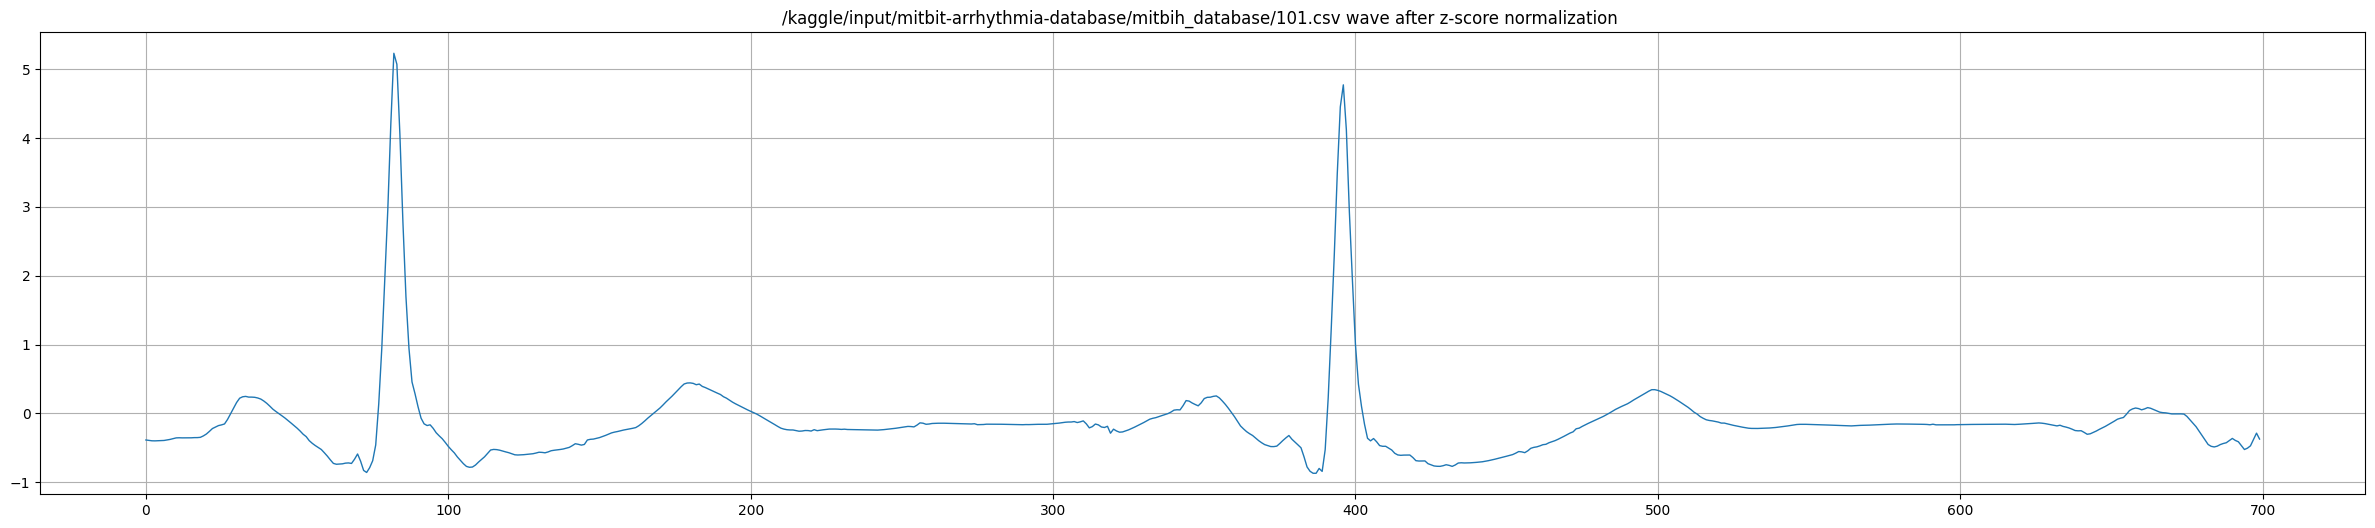

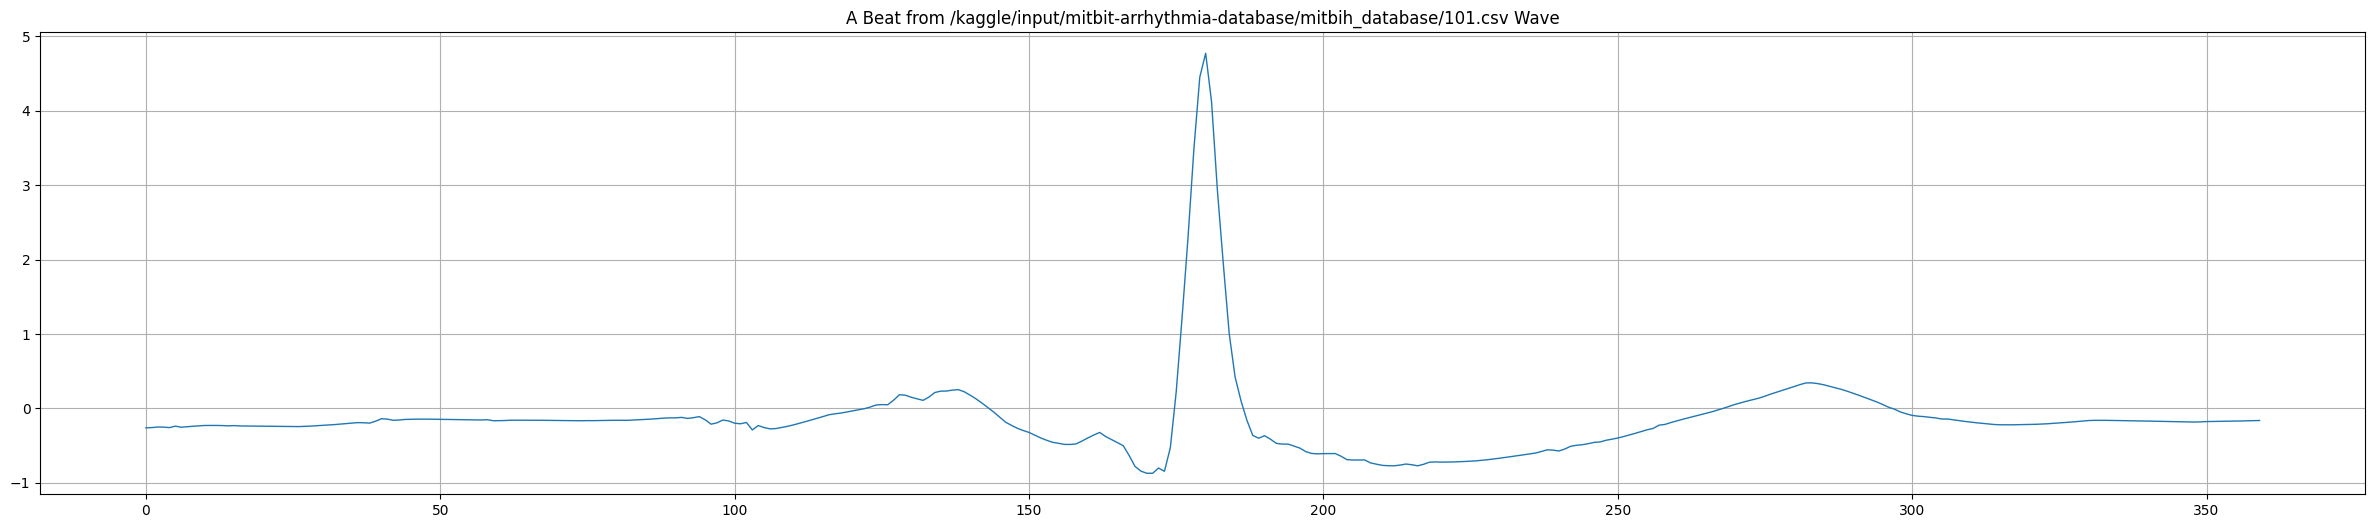

(100012, 360) (100012,)


In [7]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [8]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


### 4. Preprocessing - Balancing the classes with each class having 3000 segments

360
0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: count, dtype: int64


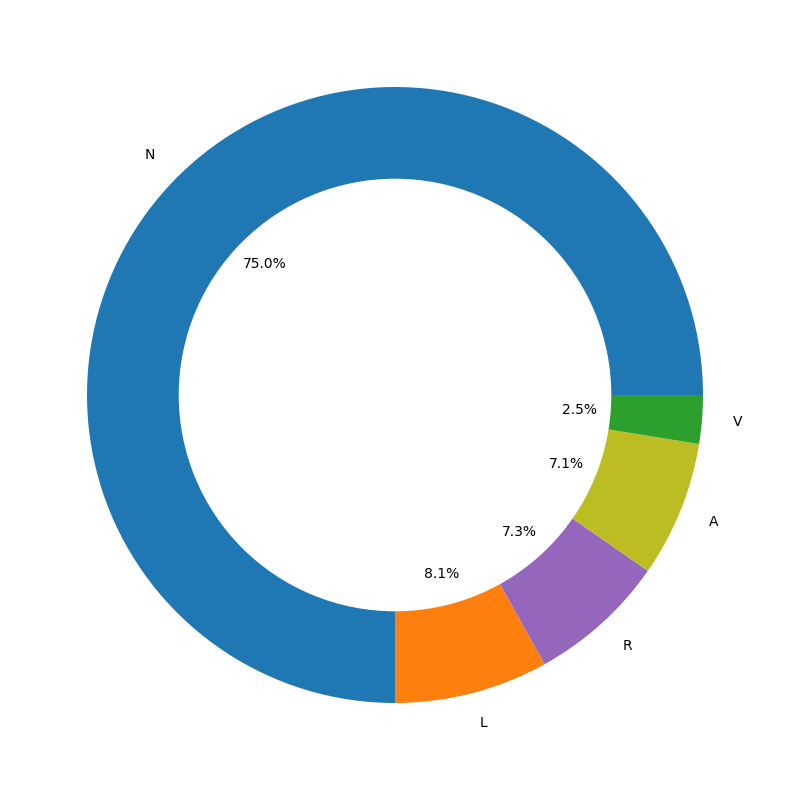

In [9]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [10]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=3000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=3000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=3000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=3000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=3000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

360
0.0    3000
1.0    3000
2.0    3000
3.0    3000
4.0    3000
Name: count, dtype: int64


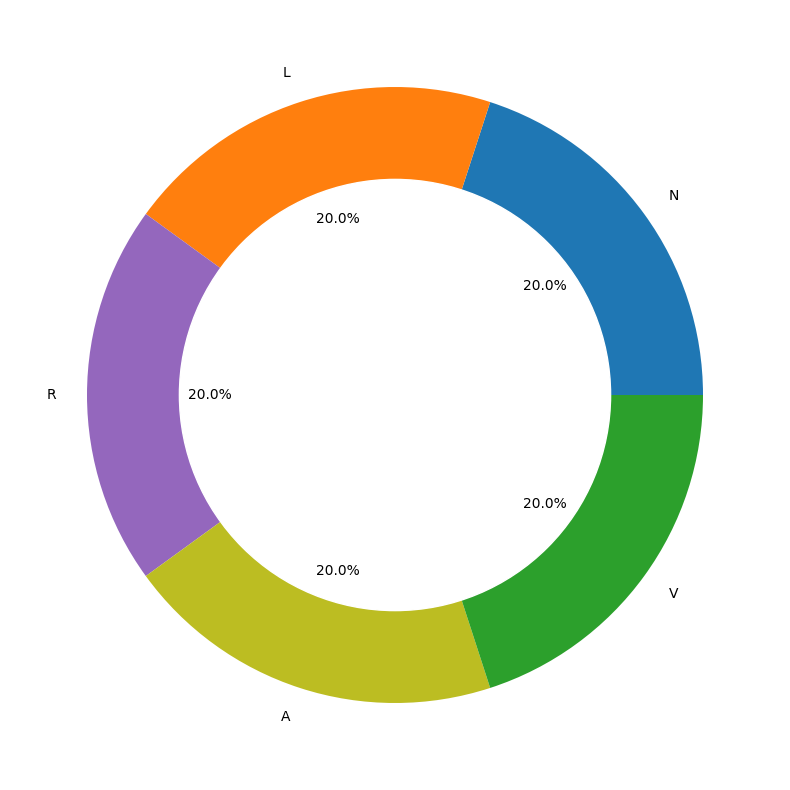

In [11]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### 5. Performing Train-Test Split before Training the model

In [12]:
# Split the original dataset into train and test sets
train, test = train_test_split(X_train_df, test_size=0.20, random_state=42)

In [13]:
# Prepare the target and features for training, validation, and test sets
target_train = train[train.shape[1]-1]
target_test = test[test.shape[1]-1]

train_y = to_categorical(target_train)
test_y = to_categorical(target_test)

In [14]:
train_x = train.iloc[:, :train.shape[1]-1].values
test_x = test.iloc[:, :test.shape[1]-1].values

train_x = train_x.reshape(len(train_x), train_x.shape[1], 1)
test_x = test_x.reshape(len(test_x), test_x.shape[1], 1)

In [15]:
print("Training set:", train_x.shape, train_y.shape)
print("Test set:", test_x.shape, test_y.shape)

Training set: (12000, 360, 1) (12000, 5)
Test set: (3000, 360, 1) (3000, 5)


### 6. Building the Model Architecture


In [20]:
# Best trial obtained from optuna:
#   Value:  0.9679999947547913
#   Params: 
#     num_layers: 3
#     num_filters_0: 64
#     num_filters_1: 64
#     num_filters_2: 96
#     kernel_size_0: 9
#     kernel_size_1: 3
#     kernel_size_2: 7
#     dropout_rate: 0.20368709608876687


#### Description of the model and the parameters for each layer

In [21]:
# Instanciate an empty model
model = Sequential()

# Adding a Convolution Layer C1
# Input shape = (360 x 1)
# Number of filters = 64
# Filter size = 9
# Padding = 'same' (output size matches input size, 360)
# Strides = 1
# Size of each feature map in C1 is (N/S) = 360/1 = 360
# Number of parameters = (9*1 + 1)*64 = 640
model.add(Conv1D(filters=64, kernel_size=9, padding='same', activation='relu',input_shape=(360, 1)))


# Adding an Average Pooling Layer S1
# Input shape = (360 x 16)
# Filter size (pool size) = 3
# Padding = 0
# Strides = 2
# Size of each feature map in S2 = (N-f+2P)/S + 1 = (360-3+0)/2 + 1 = 179
# Output shape = (179 x 16)
# No trainable parameters (pooling layers do not have weights or biases)
model.add(AvgPool1D(pool_size=3, strides=2))





# Adding a Convolution Layer C2
# Input shape = (179 x 16)
# Number of filters = 64
# Filter size = 3
# Padding = 'same' (output size matches input size)
# Strides = 1
# Size of each feature map in C2 = (N) = 179 (due to 'same' padding)
# Output shape = (179 x 64)
# Number of parameters = (3*16 + 1)*64 = 3136
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))


# Adding an Average Pooling Layer S2
# Input shape = (179 x 32)
# Number of filters = Not applicable for pooling layers
# Filter size = 3
# Padding = 0
# Strides = 2
# Output shape = (89 x 32)
# Number of parameters = 0 (pooling layers do not have parameters)
model.add(AvgPool1D(pool_size=3, strides=2))


# Adding a Convolution Layer C3
# Input shape = (44 x 64)
# Number of filters = 96
# Filter size = 7
# Padding = 'same' (output size matches input size)
# Strides = 1
# Output shape = (44 x 96)
# Number of parameters = (7*64 + 1)*96 = 43008
model.add(Conv1D(filters=96, kernel_size=7, padding='same', activation='relu'))


# Adding an Average Pooling Layer S3
# Input shape = (44 x 128)
# Number of filters = Not applicable for pooling layers
# Filter size = 3
# Padding = 0
# Strides = 2
# Output shape = (21 x 128)
# Number of parameters = 0 (pooling layers do not have parameters)
model.add(AvgPool1D(pool_size=3, strides=2))



model.add(Flatten())

model.add(Dropout(0.20368709608876687))


model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))

model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))


# Adding a Softmax layer S11
# No. of inputs = 5
# No. of outputs = 5
model.add(Softmax())


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 360, 64)           640       
_________________________________________________________________
average_pooling1d (AveragePo (None, 179, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 64)           12352     
_________________________________________________________________
average_pooling1d_1 (Average (None, 89, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 96)            43104     
_________________________________________________________________
average_pooling1d_2 (Average (None, 44, 96)            0         
_________________________________________________________________
flatten (Flatten)            (None, 4224)              0

### 7. Performing K-Fold Cross validation (K=5)

In [22]:
# Define K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
X = np.array(train_x) 
y = np.array(train_y)

In [24]:
# Directory to save models
save_dir = "kfold_models"
os.makedirs(save_dir, exist_ok=True)

In [25]:
fold = 1
# Loop through each fold
for train_index, val_index in kf.split(X):
    # Split the data into training and validation sets
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Build and compile your model here
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=9, padding='same', activation='relu',input_shape=(360, 1)))
    model.add(AvgPool1D(pool_size=3, strides=2))
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(AvgPool1D(pool_size=3, strides=2))
    model.add(Conv1D(filters=96, kernel_size=7, padding='same', activation='relu'))
    model.add(AvgPool1D(pool_size=3, strides=2))
    model.add(Flatten())
    model.add(Dropout(0.20368709608876687))
    model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
    model.add(Softmax())

    # Compiling the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=36,
        epochs=60,
        verbose=1,
        validation_data=(X_val, y_val)
    )

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    # Save training history
    history_path = os.path.join(save_dir, f"history_fold_{fold}.json")
    with open(history_path, "w") as f:
        json.dump(history.history, f)
        
    print(f"Training history for fold {fold} saved at: {history_path}")

    # Saving Model
    model_path = os.path.join(save_dir, f"model_fold_{fold}.h5")
    model.save(model_path)
    print(f"Model for fold {fold} saved at: {model_path}")
    
    fold += 1
    print(f"="*80)

Epoch 1/60
267/267 [==============================] - 8s 7ms/step - loss: 0.7496 - accuracy: 0.7449 - val_loss: 0.3070 - val_accuracy: 0.9187
Epoch 2/60
267/267 [==============================] - 1s 4ms/step - loss: 0.2605 - accuracy: 0.9253 - val_loss: 0.2680 - val_accuracy: 0.9271
Epoch 3/60
267/267 [==============================] - 1s 4ms/step - loss: 0.2051 - accuracy: 0.9383 - val_loss: 0.2587 - val_accuracy: 0.9304
Epoch 4/60
267/267 [==============================] - 1s 4ms/step - loss: 0.1668 - accuracy: 0.9515 - val_loss: 0.2448 - val_accuracy: 0.9346
Epoch 5/60
267/267 [==============================] - 1s 4ms/step - loss: 0.1541 - accuracy: 0.9546 - val_loss: 0.1914 - val_accuracy: 0.9521
Epoch 6/60
267/267 [==============================] - 1s 4ms/step - loss: 0.1312 - accuracy: 0.9602 - val_loss: 0.2096 - val_accuracy: 0.9450
Epoch 7/60
267/267 [==============================] - 1s 4ms/step - loss: 0.1350 - accuracy: 0.9629 - val_loss: 0.1861 - val_accuracy: 0.9533
Epoch 

In [26]:
# Directory where history JSON files are stored
history_dir = "kfold_models"

# Initialize lists to store metrics for each fold
results = {
    "Fold": [],
    "Train Accuracy": [],
    "Train Loss": [],
    "Validation Accuracy": [],
    "Validation Loss": []
}

# Loop through the JSON files for each fold
for fold in range(1, 6):  # Assuming 5 folds
    history_path = os.path.join(history_dir, f"history_fold_{fold}.json")
    
    # Load the history file
    with open(history_path, "r") as f:
        history = json.load(f)
    
    # Extract the final metrics from the history
    train_loss = history["loss"][-1]
    train_acc = history["accuracy"][-1]
    val_loss = history["val_loss"][-1]
    val_acc = history["val_accuracy"][-1]
    
    # Append the results for the current fold
    results["Fold"].append(fold)
    results["Train Accuracy"].append(train_acc)
    results["Train Loss"].append(train_loss)
    results["Validation Accuracy"].append(val_acc)
    results["Validation Loss"].append(val_loss)

#### Summary of KFolds

In [27]:
# Convert results to a pandas DataFrame
results_df = pd.DataFrame(results)

In [31]:
results_df

,Fold,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss
0,1,0.995938,0.031755,0.967500,0.215218
1,2,0.994375,0.034001,0.975417,0.118986
2,3,0.995625,0.035943,0.977500,0.133434
3,4,0.992813,0.041060,0.976667,0.108020
4,5,0.991146,0.046057,0.980833,0.093251


### 8. Saving KFold models and their training history

In [29]:
!zip -r output_folder.zip kfold_models

  adding: kfold_models/ (stored 0%)
  adding: kfold_models/model_fold_1.h5 (deflated 8%)
  adding: kfold_models/history_fold_5.json (deflated 61%)
  adding: kfold_models/history_fold_2.json (deflated 60%)
  adding: kfold_models/model_fold_2.h5 (deflated 8%)
  adding: kfold_models/history_fold_1.json (deflated 60%)
  adding: kfold_models/model_fold_5.h5 (deflated 8%)
  adding: kfold_models/model_fold_3.h5 (deflated 7%)
  adding: kfold_models/history_fold_3.json (deflated 61%)
  adding: kfold_models/model_fold_4.h5 (deflated 8%)
  adding: kfold_models/history_fold_4.json (deflated 60%)


In [30]:
!ls /kaggle/working/

kfold_models  output_folder.zip


### 9. Finding the performance on test Data

**Plotting the loss convergence**

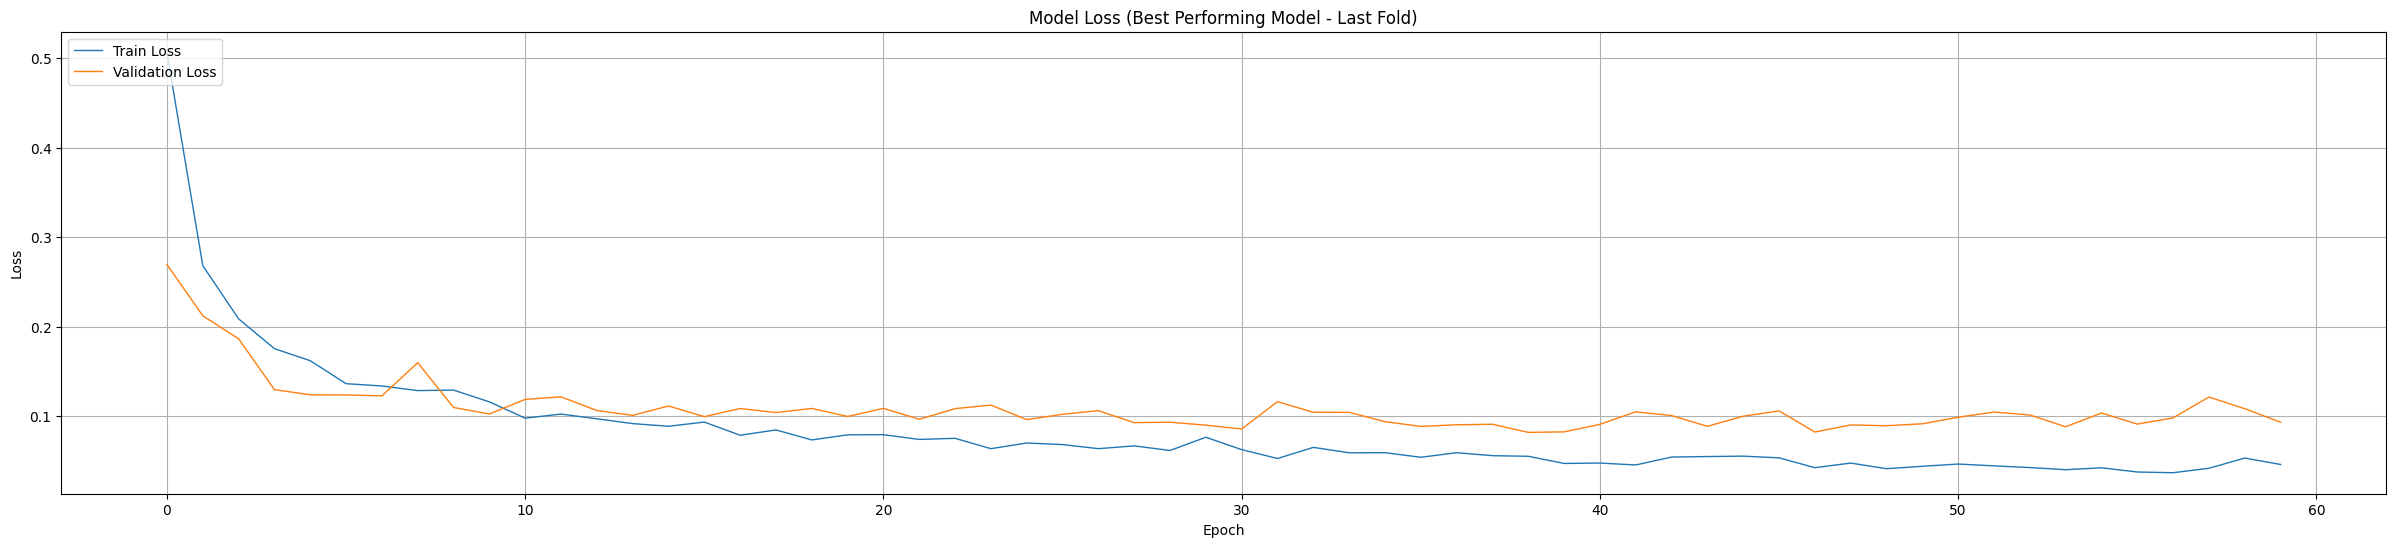

In [16]:
# Path to the history file for the last fold (best-performing model)
history_path = "/kaggle/input/output-folder/kfold_models_not_randomized/history_fold_5.json"  # Update this with the correct file name if needed

# Load the history file
with open(history_path, "r") as f:
    best_model_history = json.load(f)

# Plot loss
plt.plot(best_model_history['loss'], label='Train Loss')
plt.plot(best_model_history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Best Performing Model - Last Fold)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

**Plotting accuracy**

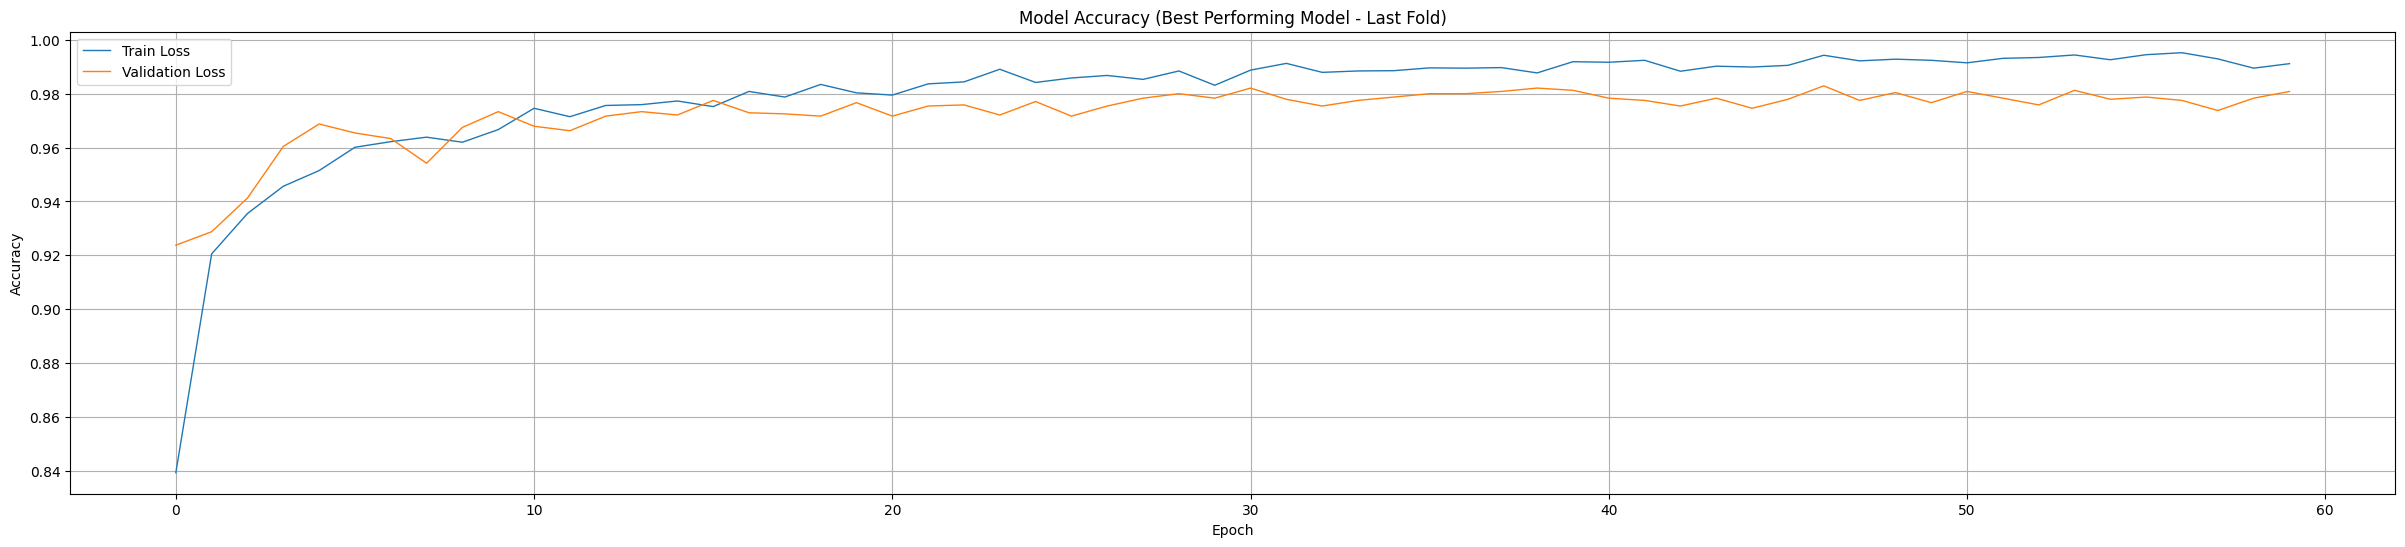

In [17]:
# Plot Accuracy
plt.plot(best_model_history['accuracy'], label='Train Loss')
plt.plot(best_model_history['val_accuracy'], label='Validation Loss')
plt.title('Model Accuracy (Best Performing Model - Last Fold)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [17]:
# List to store true labels and predictions from all folds
all_true_labels = []
all_pred_probs = []
all_pred_classes = []

# Number of folds
num_folds = 5  # Adjust as per your k-fold cross-validation

# Iterate through each fold's model
for fold in range(1, num_folds + 1):
    print(f"Evaluating Fold {fold}...")
    
    # Load the model for the current fold
    model_path = f"/kaggle/input/output-folder/kfold_models_not_randomized/model_fold_{fold}.h5"  # Update path as per your folder structure
    model = load_model(model_path)
    
    # Predict probabilities for the test data of the current fold
    test_predictions = model.predict(test_x)  # Replace with fold-specific test_x
    predicted_classes = np.argmax(test_predictions, axis=1)  # Convert probabilities to class labels
    
    # Append predictions and true labels
    all_pred_probs.append(test_predictions)
    all_pred_classes.append(predicted_classes)
    all_true_labels.append(np.argmax(test_y, axis=1))  

Evaluating Fold 1...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluating Fold 2...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluating Fold 3...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluating Fold 4...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Evaluating Fold 5...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [18]:
# Combine all folds' results
all_pred_probs = np.concatenate(all_pred_probs, axis=0)
all_pred_classes = np.concatenate(all_pred_classes, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

# Compute classification report
report = classification_report(all_true_labels, all_pred_classes, digits=2, output_dict=True)

# Compute AUROC and AUPRC
auroc = roc_auc_score(np.eye(len(np.unique(all_true_labels)))[all_true_labels], all_pred_probs, multi_class="ovr")
auprc = average_precision_score(np.eye(len(np.unique(all_true_labels)))[all_true_labels], all_pred_probs, average="macro")

In [38]:
# Display Results
print("Combined Classification Report Across All Folds:")
for fold_num, metrics in report.items():
    if isinstance(metrics, dict):  
        print(f"Fold {fold_num}:")
        print(f"Precision={metrics['precision']}") 
        print(f"Recall={metrics['recall']}")
        print(f"F1-Score={metrics['f1-score']}")
        print("="*50)


print("\nSummary Metrics Across All Folds:")
print(f"F1 Score (weighted): {report['weighted avg']['f1-score']:.4f}")
print(f"Precision (weighted): {report['weighted avg']['precision']:.4f}")
print(f"Recall (weighted): {report['weighted avg']['recall']:.4f}")
print(f"AUROC: {auroc:.4f}")
print(f"AUPRC: {auprc:.4f}")

Combined Classification Report Across All Folds:
Fold 0:
Precision=0.9684424838819138
Recall=0.9529215358931553
F1-Score=0.9606193200942443
Fold 1:
Precision=0.9949542730999684
Recall=0.9921383647798742
F1-Score=0.9935443237285466
Fold 2:
Precision=0.9979035639412998
Recall=0.9951219512195122
F1-Score=0.9965108164689461
Fold 3:
Precision=0.962425840474621
Recall=0.9749582637729549
F1-Score=0.968651517664621
Fold 4:
Precision=0.9792364367046216
Recall=0.9878378378378379
F1-Score=0.9835183316515305
Fold macro avg:
Precision=0.980592519620485
Recall=0.9805955907006669
F1-Score=0.9805688619215778
Fold weighted avg:
Precision=0.9806285534041953
Recall=0.9806
F1-Score=0.9805891608999323

Summary Metrics Across All Folds:
F1 Score (weighted): 0.9806
Precision (weighted): 0.9801
Recall (weighted): 0.9803
AUROC: 0.9989
AUPRC: 0.9962


In [19]:
overall_accuracy = accuracy_score(all_true_labels, all_pred_classes)
print(f"Overall Accuracy: {overall_accuracy}")

Overall Accuracy: 0.9806


#### Class-wise accuracy

In [20]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(all_true_labels, all_pred_classes)

# Compute class-wise accuracy
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print class-wise accuracies
for i, acc in enumerate(class_accuracies):
    print(f"Class {i} Accuracy: {acc:.4f}")


Class 0 Accuracy: 0.9529
Class 1 Accuracy: 0.9921
Class 2 Accuracy: 0.9951
Class 3 Accuracy: 0.9750
Class 4 Accuracy: 0.9878


### 10. Inspecting Feature Extraction by CNN through PCA

In [41]:
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the intermediate layer name
layer_name = 'dense_10'  # Replace with the actual layer name in your model
intermediate_model = Model(inputs=best_model.input, outputs=best_model.get_layer(layer_name).output)

# Extract intermediate features
intermediate_features = intermediate_model.predict(test_x)  # test_x should be your test dataset

In [42]:
# Apply PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(intermediate_features)

In [43]:
# Print explained variance
print(f"Explained variance by components: {pca.explained_variance_ratio_}")

Explained variance by components: [0.4570926  0.29304564]


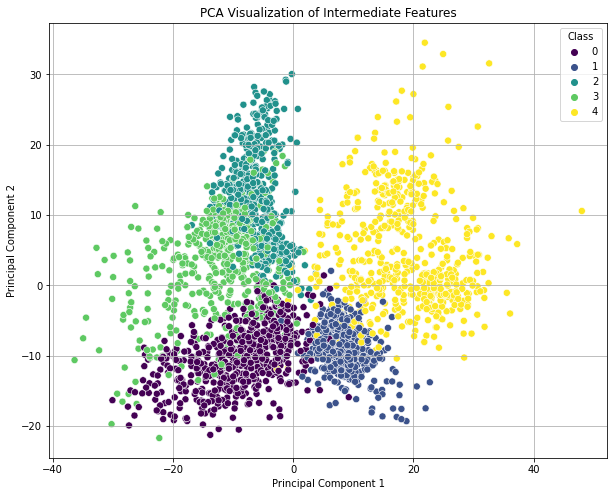

In [45]:
# Visualize PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=true_classes, palette="viridis", s=50)
plt.title("PCA Visualization of Intermediate Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class", loc='best')
plt.show()

In [50]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Define a model that outputs activations from a specific convolutional layer
layer_name = 'conv1d_15'  # Replace with your convolutional layer's name
intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Pass a single ECG signal through the intermediate model
test_sample = test_x[0:1]  # Select a single test sample
activation_maps = intermediate_model.predict(test_sample)

print("Activation Maps Shape:", activation_maps.shape)
# Shape: (batch_size, sequence_length, num_filters)


Activation Maps Shape: (1, 360, 64)


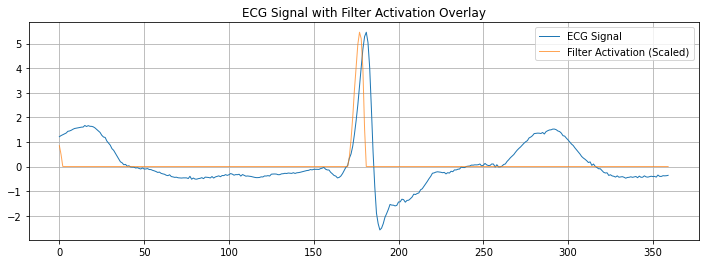

In [51]:
# Normalize the first filter's activation map
filter_activation = activation_maps[0, :, 0]
normalized_activation = filter_activation / max(filter_activation)

# Plot the original ECG signal and the activation map
plt.figure(figsize=(12, 4))
plt.plot(test_sample[0, :, 0], label="ECG Signal")  # Plot the original signal
plt.plot(normalized_activation * max(test_sample[0, :, 0]), label="Filter Activation (Scaled)", alpha=0.7)
plt.legend()
plt.title("ECG Signal with Filter Activation Overlay")
plt.show()


This plot overlays the ECG signal and the filter activation, which gives insights into which regions of the signal are strongly activating the selected filter.

Interpretation
Filter Activation Peaks:

The orange line shows the scaled activation of the filter, which peaks significantly near the sharp QRS complex in the ECG signal (around index 150–200).
This suggests that the filter is likely specialized in detecting high-frequency or high-amplitude components, such as the QRS complex.
Focus of the Filter:

Since the QRS complex corresponds to the ventricular depolarization, the filter might be focusing on sharp transitions or high-energy regions in the signal.
Other Regions:

The activation is minimal in flat or low-amplitude regions (e.g., P-wave and T-wave areas), meaning this filter doesn't respond strongly to those segments.